In [5]:
!pip3 install category_encoders

In [6]:
!pip3 install xgboost

In [7]:
'''import libraries'''
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import classification_report

In [8]:
'''Load CSVs'''
energia_2021 = pd.read_csv('./datasets/energia_202109-202112.csv')
energia_2022 = pd.read_csv('./datasets/energia_202201-202212.csv')
meteo_2021 = pd.read_csv('./datasets/meteo_202109-202112.csv')
meteo_2022 = pd.read_csv('./datasets/meteo_202201-202212.csv')

teste_energia = pd.read_csv('./datasets/energia_202301-202304.csv')
teste_meteo = pd.read_csv('./datasets/meteo_202301-202304.csv')

## Análise dos Dados

#### Full Join dos datasets

In [9]:
energia_21 = energia_2021.copy()
energia_22 = energia_2022.copy() 
energia = pd.merge(energia_21, energia_22, how="outer", on=['Data', 'Hora','Normal (kWh)','Horário Económico (kWh)','Autoconsumo (kWh)','Injeção na rede (kWh)'])

In [10]:
meteo_21 = meteo_2021.copy()
meteo_22 = meteo_2022.copy() 
meteo = pd.merge(meteo_21, meteo_22, how="outer", on=['dt','dt_iso','city_name','temp', 'feels_like', 'temp_min', 'temp_max' , 'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'])

### Inner Join dos datasets Energia e Meteorologia

In [11]:
energia['Data_Hora'] = energia['Data'] + ":" + energia['Hora'].astype(str)
energia['dt'] = energia['Data_Hora'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d:%H').timestamp()).astype('int64')

In [12]:
e_m = pd.merge(meteo, energia, how="inner", on= 'dt')

Teste

In [13]:
teste_energia['Data_Hora'] = teste_energia['Data'] + ":" + teste_energia['Hora'].astype(str)
teste_energia['dt'] = teste_energia['Data_Hora'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d:%H').timestamp()).astype('int64')

In [14]:
teste = pd.merge(teste_meteo, teste_energia, how="outer", on= 'dt')

## Tratamento dos Dados

### Simplificação dos nomes das features

In [15]:
e_m.rename(columns={"dt": "Timestamp"}, inplace=True)
e_m.rename(columns={"temp": "Temperatura"}, inplace=True)
e_m.rename(columns={"feels_like": "Sensação Térmica"}, inplace=True)
e_m.rename(columns={"temp_min": "Temperatura Mínima"}, inplace=True)
e_m.rename(columns={"temp_max": "Temperatura Máxima"}, inplace=True)
e_m.rename(columns={"pressure": "Pressão Atmosférica"}, inplace=True)
e_m.rename(columns={"humidity": "Humidade"}, inplace=True)
e_m.rename(columns={"wind_speed": "Velocidade Vento"}, inplace=True)
e_m.rename(columns={"rain_1h": "Precipitação Média"}, inplace=True)
e_m.rename(columns={"clouds_all": "Nebulosidade"}, inplace=True)
e_m.rename(columns={"weather_description": "Estado do Tempo"}, inplace=True)
e_m.rename(columns={"Normal (kWh)": "Normal"}, inplace=True)
e_m.rename(columns={"Horário Económico (kWh)": "Horário Económico"}, inplace=True)
e_m.rename(columns={"Autoconsumo (kWh)": "Autoconsumo"}, inplace=True)
e_m.rename(columns={"Injeção na rede (kWh)": "Injeção na Rede"}, inplace=True)

In [16]:
teste.rename(columns={"dt": "Timestamp"}, inplace=True)
teste.rename(columns={"temp": "Temperatura"}, inplace=True)
teste.rename(columns={"feels_like": "Sensação Térmica"}, inplace=True)
teste.rename(columns={"temp_min": "Temperatura Mínima"}, inplace=True)
teste.rename(columns={"temp_max": "Temperatura Máxima"}, inplace=True)
teste.rename(columns={"pressure": "Pressão Atmosférica"}, inplace=True)
teste.rename(columns={"humidity": "Humidade"}, inplace=True)
teste.rename(columns={"wind_speed": "Velocidade Vento"}, inplace=True)
teste.rename(columns={"rain_1h": "Precipitação Média"}, inplace=True)
teste.rename(columns={"clouds_all": "Nebulosidade"}, inplace=True)
teste.rename(columns={"weather_description": "Estado do Tempo"}, inplace=True)
teste.rename(columns={"Normal (kWh)": "Normal"}, inplace=True)
teste.rename(columns={"Horário Económico (kWh)": "Horário Económico"}, inplace=True)
teste.rename(columns={"Autoconsumo (kWh)": "Autoconsumo"}, inplace=True)
teste.rename(columns={"Injeção na rede (kWh)": "Injeção na Rede"}, inplace=True)

### Remoção de features

In [17]:
e_m.drop(['city_name','sea_level','grnd_level'], axis=1, inplace=True)

In [18]:
teste.drop(['city_name','sea_level','grnd_level'], axis=1, inplace=True)

In [19]:
e_m.drop(['Data_Hora'], axis=1, inplace=True)

In [20]:
teste.drop(['Data_Hora'], axis=1, inplace=True)

### Alteração de datas

In [21]:
#def seconds_to_hours(x):
#    return x / 3600

In [22]:
#e_m['Timestamp'] = e_m['Timestamp'].apply(lambda x: seconds_to_hours(x))

In [23]:
#teste['Timestamp'] = teste['Timestamp'].apply(lambda x: seconds_to_hours(x))

In [24]:
e_m.drop(['dt_iso'], axis=1, inplace=True)

In [25]:
teste.drop(['dt_iso'], axis=1, inplace=True)

#### Adicionar colunas a partir da data

Converter o tipo de dados da coluna 'timestamp' para datetime

In [26]:
e_m['Data'] = pd.to_datetime(e_m['Data'], format='%Y-%m-%d', errors='coerce')
assert e_m['Data'].isnull().sum() == 0, 'missing Data'
e_m['Data'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: Data, dtype: datetime64[ns]

In [27]:
teste['Data'] = pd.to_datetime(teste['Data'], format='%Y-%m-%d', errors='coerce')
assert teste['Data'].isnull().sum() == 0, 'missing Data'
teste['Data'].head()

0   2023-01-01
1   2023-01-01
2   2023-01-01
3   2023-01-01
4   2023-01-01
Name: Data, dtype: datetime64[ns]

Criação de várias colunas com as partes extraídas da Data

In [28]:
e_m['Ano'] = e_m['Data'].dt.year 
e_m['Mês'] = e_m['Data'].dt.month 
e_m['Dia'] = e_m['Data'].dt.day
e_m.head()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Data,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Ano,Mês,Dia
0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,NaN,87,overcast clouds,2021-09-29,0,0.0,0.0,0.0,NaN,2021,9,29
1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,NaN,91,overcast clouds,2021-09-29,1,0.0,0.0,0.0,NaN,2021,9,29
2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,NaN,93,overcast clouds,2021-09-29,2,0.0,0.0,0.0,NaN,2021,9,29
3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,NaN,95,overcast clouds,2021-09-29,3,0.0,0.0,0.0,NaN,2021,9,29
4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,NaN,93,overcast clouds,2021-09-29,4,0.0,0.0,0.0,NaN,2021,9,29


In [29]:
teste['Ano'] = teste['Data'].dt.year 
teste['Mês'] = teste['Data'].dt.month 
teste['Dia'] = teste['Data'].dt.day
teste.head()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Data,Hora,Normal,Horário Económico,Autoconsumo,Ano,Mês,Dia
0,1672531200,12.93,12.76,12.72,13.43,1019.0,95.0,2.02,3.72,100.0,moderate rain,2023-01-01,0,0.0,0.467,0.0,2023,1,1
1,1672534800,13.49,13.38,13.43,13.90,1018.0,95.0,2.18,3.26,100.0,moderate rain,2023-01-01,1,0.0,0.577,0.0,2023,1,1
2,1672538400,13.55,13.44,13.48,14.82,1017.0,95.0,2.88,2.44,100.0,moderate rain,2023-01-01,2,0.0,0.346,0.0,2023,1,1
3,1672542000,13.61,13.51,12.01,14.82,1016.0,95.0,3.63,1.74,100.0,moderate rain,2023-01-01,3,0.0,0.270,0.0,2023,1,1
4,1672545600,13.59,13.49,12.01,14.82,1015.0,95.0,4.58,1.13,100.0,moderate rain,2023-01-01,4,0.0,0.252,0.0,2023,1,1


In [30]:
teste.nunique()

Timestamp              2256
Temperatura             889
Sensação Térmica       1007
Temperatura Mínima      169
Temperatura Máxima      174
Pressão Atmosférica      31
Humidade                 71
Velocidade Vento        512
Precipitação Média      120
Nebulosidade             99
Estado do Tempo           8
Data                     94
Hora                     24
Normal                  709
Horário Económico       490
Autoconsumo             485
Ano                       1
Mês                       4
Dia                      31
dtype: int64

In [31]:
e_m.drop(['Data','Ano'], axis=1, inplace=True)

In [32]:
teste.drop(['Data','Ano'], axis=1, inplace=True)

### Converter tipos de dados categóricos para numéricos

#### Injeção na Rede

In [33]:
#e_m['Injeção na Rede'] = pd.factorize(e_m['Injeção na Rede'])[0] + 1

In [34]:
from sklearn.preprocessing import LabelEncoder    

In [35]:
lb_make = LabelEncoder()
e_m['Injeção na Rede'] = lb_make.fit_transform(e_m['Injeção na Rede'])

#### Estado do Tempo

In [36]:
#encoder = ce.BinaryEncoder(cols = ['Estado do Tempo'])
#e_m = encoder.fit_transform(e_m)

In [37]:
#encoder = ce.BinaryEncoder(cols = ['Estado do Tempo'])
#teste = encoder.fit_transform(teste)

In [38]:
lb_make = LabelEncoder()
e_m['Estado do Tempo'] = lb_make.fit_transform(e_m['Estado do Tempo'])

In [39]:
lb_make = LabelEncoder()
teste['Estado do Tempo'] = lb_make.fit_transform(teste['Estado do Tempo'])

### Normalização

In [40]:
from sklearn import preprocessing

In [41]:
e_m.describe()

,Timestamp,Temperatura,Sensação Térmica,Temperatura Mínima,Temperatura Máxima,Pressão Atmosférica,Humidade,Velocidade Vento,Precipitação Média,Nebulosidade,Estado do Tempo,Hora,Normal,Horário Económico,Autoconsumo,Injeção na Rede,Mês,Dia
count,1.101600e+04,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,2284.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,1.652701e+09,16.182991,15.826868,14.195064,17.288098,1018.396605,76.570715,2.672039,0.896642,54.000908,4.374818,11.500000,0.202278,0.159714,0.117314,3.227487,7.433551,15.803922
std,1.144868e+07,5.756972,6.264860,4.956014,6.164689,6.203379,16.268260,1.476158,1.079381,40.553002,2.403911,6.922501,0.349478,0.271792,0.176762,1.346130,3.578335,8.835905
min,1.632874e+09,0.320000,-2.190000,-0.640000,1.330000,994.000000,19.000000,0.060000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.642787e+09,12.080000,11.507500,10.720000,12.890000,1015.000000,66.000000,1.620000,0.210000,7.000000,3.000000,5.750000,0.000000,0.000000,0.000000,3.000000,4.000000,8.000000
50%,1.652701e+09,15.625000,15.230000,14.230000,16.260000,1018.000000,81.000000,2.400000,0.460000,60.000000,5.000000,11.500000,0.000000,0.000000,0.000000,4.000000,8.000000,16.000000
75%,1.662614e+09,19.270000,19.260000,17.490000,20.340000,1022.000000,91.000000,3.420000,1.092500,98.000000,7.000000,17.250000,0.314000,0.288000,0.227000,4.000000,11.000000,23.000000
max,1.672528e+09,40.850000,41.330000,36.720000,41.450000,1034.000000,100.000000,11.100000,7.450000,100.000000,7.000000,23.000000,3.251000,6.978000,1.192000,4.000000,12.000000,31.000000


In [42]:
#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
#e_m[['Timestamp']] = min_max_scaler.fit_transform(e_m[['Timestamp']])
#e_m[['Temperatura']] = min_max_scaler.fit_transform(e_m[['Temperatura']])
#e_m[['Sensação Térmica']] = min_max_scaler.fit_transform(e_m[['Sensação Térmica']])
#e_m[['Temperatura Mínima']] = min_max_scaler.fit_transform(e_m[['Temperatura Mínima']])
#e_m[['Temperatura Máxima']] = min_max_scaler.fit_transform(e_m[['Temperatura Máxima']])
#e_m[['Pressão Atmosférica']] = min_max_scaler.fit_transform(e_m[['Pressão Atmosférica']])
#e_m[['Humidade']] = min_max_scaler.fit_transform(e_m[['Humidade']])
#Velocidade Vento
#e_m[['Velocidade Vento']] = min_max_scaler.fit_transform(e_m[['Velocidade Vento']])

#Precipitação Média
#e_m[['Precipitação Média']] = min_max_scaler.fit_transform(e_m[['Precipitação Média']])
#e_m[['Nebulosidade']] = min_max_scaler.fit_transform(e_m[['Nebulosidade']])

#e_m[['Estado do Tempo']] = min_max_scaler.fit_transform(e_m[['Estado do Tempo']])
#e_m[['Normal']] = min_max_scaler.fit_transform(e_m[['Normal']])
#e_m[['Horário Económico']] = min_max_scaler.fit_transform(e_m[['Horário Económico']])
#e_m[['Autoconsumo']] = min_max_scaler.fit_transform(e_m[['Autoconsumo']])


In [43]:
#teste[['Timestamp']] = min_max_scaler.fit_transform(teste[['Timestamp']])
#teste[['Temperatura']] = min_max_scaler.fit_transform(teste[['Temperatura']])
#teste[['Sensação Térmica']] = min_max_scaler.fit_transform(teste[['Sensação Térmica']])
#teste[['Temperatura Mínima']] = min_max_scaler.fit_transform(teste[['Temperatura Mínima']])
#teste[['Temperatura Máxima']] = min_max_scaler.fit_transform(teste[['Temperatura Máxima']])
#teste[['Pressão Atmosférica']] = min_max_scaler.fit_transform(teste[['Pressão Atmosférica']])
#teste[['Humidade']] = min_max_scaler.fit_transform(teste[['Humidade']])
#teste[['Velocidade Vento']] = min_max_scaler.fit_transform(teste[['Velocidade Vento']])
#teste[['Precipitação Média']] = min_max_scaler.fit_transform(teste[['Precipitação Média']])
#teste[['Nebulosidade']] = min_max_scaler.fit_transform(teste[['Nebulosidade']])
#teste[['Estado do Tempo']] = min_max_scaler.fit_transform(teste[['Estado do Tempo']])
#teste[['Normal']] = min_max_scaler.fit_transform(teste[['Normal']])
#teste[['Horário Económico']] = min_max_scaler.fit_transform(teste[['Horário Económico']])
#teste[['Autoconsumo']] = min_max_scaler.fit_transform(teste[['Autoconsumo']])

### Tratamento de Outliers

In [44]:
from scipy.stats.mstats import winsorize

In [45]:
def get_outliers(lower,upper,field):
    Q1 = e_m[field].quantile(0.25)
    Q3 = e_m[field].quantile(0.75)
    IQR = Q3-Q1

    lower_lim = Q1 - lower * IQR
    upper_lim = Q3 + upper * IQR

    out_low = (e_m[field]<lower_lim)
    out_up = (e_m[field]>upper_lim)

    return [out_low,out_up]

##### Temperatura

In [46]:
#e_m['Temperatura'] = winsorize(e_m['Temperatura'], (0.000182,0.02442))

##### Sensação Térmica

In [47]:
#e_m['Sensação Térmica'] = winsorize(e_m['Sensação Térmica'], (0.0003,0.0242))

##### Temperatura Mínima

In [48]:
outliers_low, outliers_up = get_outliers(1.46,1.4,'Temperatura Mínima')

median = e_m['Temperatura Mínima'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Temperatura Mínima'] = median

##### Temperatura Máxima

In [49]:
outliers_low, outliers_up = get_outliers(1.55,1.31,'Temperatura Máxima')

In [50]:
e_m = e_m[~(outliers_low|outliers_up)]

##### Pressão Atmosférica

In [51]:
#e_m['Pressão Atmosférica'] = winsorize(e_m['Pressão Atmosférica'], (0.0258,0.0025))

##### Humidade

In [52]:
#e_m['Humidade'] = winsorize(e_m['Humidade'], (0.0058,0.0))

##### Velocidade Vento

In [53]:
outliers_low, outliers_up = get_outliers(1.5,1.15,'Velocidade Vento')

median = e_m['Velocidade Vento'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Velocidade Vento'] = median

##### Precipitação Média

##### Normal

In [54]:
#e_m['Normal'] = winsorize(e_m['Normal'], (0.0,0.0683))

##### Horário Económico

In [55]:
outliers_low, outliers_up = get_outliers(1.5,1.3,'Horário Económico')

median = e_m['Horário Económico'].median()

# Substituindo os outliers na coluna 'Temperatura' pelo valor da mediana
e_m.loc[outliers_low | outliers_up, 'Horário Económico'] = median

##### Autoconsumo

In [56]:
outliers_low, outliers_up = get_outliers(1.5,1.23,'Autoconsumo')

In [57]:
e_m = e_m[~(outliers_low|outliers_up)]

### Tratamento de Missing Values

##### Temperatura

In [58]:
#teste['Temperatura'].fillna(teste['Temperatura'].median(), inplace=True)

##### Sensação Térmica

In [59]:
#teste['Sensação Térmica'].fillna(teste['Sensação Térmica'].median(), inplace=True)

##### Temperatura Mínima

In [60]:
#teste['Temperatura Mínima'].fillna(teste['Temperatura Mínima'].median(), inplace=True)

##### Temperatura Máxima

In [61]:
#teste['Temperatura Máxima'].fillna(teste['Temperatura Máxima'].median(), inplace=True)

##### Pressão Atmosférica

In [62]:
#teste['Pressão Atmosférica'].fillna(teste['Pressão Atmosférica'].median(), inplace=True)

##### Humidade

In [63]:
#teste['Humidade'].fillna(teste['Humidade'].median(), inplace=True)

##### Velocidade Vento

In [64]:
#teste['Velocidade Vento'].fillna(teste['Velocidade Vento'].median(), inplace=True)

##### Precipitação Média

In [65]:
#e_m.drop(['Precipitação Média'], axis=1, inplace=True)

In [66]:
#teste.drop(['Precipitação Média'], axis=1, inplace=True)

##### Nebulosidade

In [67]:
#teste['Nebulosidade'].fillna(teste['Nebulosidade'].median(), inplace=True)

### Exploratory Data Analysis 

In [68]:
#sns.pairplot(e_m)

<Axes: >

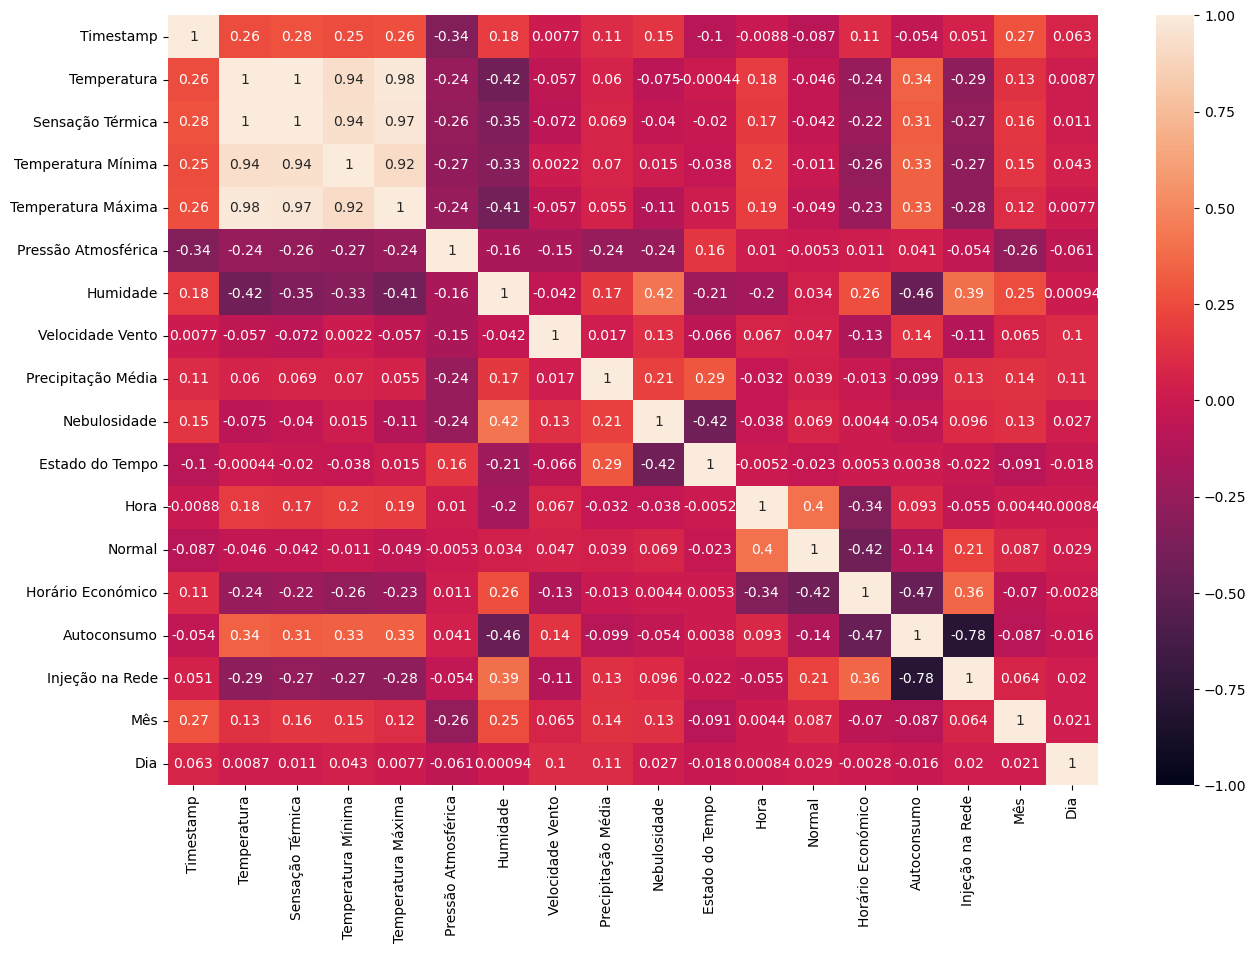

In [69]:
fig = plt.figure(figsize = (15,10))
incidents_corr = e_m.corr(method = 'pearson')
sns.heatmap(e_m.corr(),vmin=-1,annot = True)

Drop das features muito correlacionadas

In [70]:
e_m.drop(['Sensação Térmica','Temperatura','Temperatura Mínima'], axis=1, inplace=True)
teste.drop(['Sensação Térmica','Temperatura','Temperatura Mínima'], axis=1, inplace=True)

## Modelos

In [71]:
X = e_m.drop(['Injeção na Rede'], axis=1)   # input features - tudo exceto o target
y = e_m['Injeção na Rede'].to_frame()       # target feature - Injeção na Rede

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011 entries, 10821 to 1168
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            2011 non-null   int64  
 1   Temperatura Máxima   2011 non-null   float64
 2   Pressão Atmosférica  2011 non-null   int64  
 3   Humidade             2011 non-null   int64  
 4   Velocidade Vento     2011 non-null   float64
 5   Precipitação Média   450 non-null    float64
 6   Nebulosidade         2011 non-null   int64  
 7   Estado do Tempo      2011 non-null   int32  
 8   Hora                 2011 non-null   int64  
 9   Normal               2011 non-null   float64
 10  Horário Económico    2011 non-null   float64
 11  Autoconsumo          2011 non-null   float64
 12  Mês                  2011 non-null   int32  
 13  Dia                  2011 non-null   int32  
dtypes: float64(6), int32(3), int64(5)
memory usage: 212.1 KB


### XGBoost

Definir hiperparêmetros

In [73]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1]
}

In [74]:
bst = xgb.XGBClassifier(scale_pos_weight={4:1, 1:2}, objective='binary:logistic', random_state = 2023)

In [75]:
# Use GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(bst, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Obtenha os melhores hiperparâmetros e o modelo ajustado
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\xgboost\core.py:160: UserWarning: [23:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\xgboost\core.py:160: UserWarning: [23:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\xgboost\core.py:160: UserWarning: [23:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning

c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\xgboost\core.py:160: UserWarning: [23:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\xgboost\core.py:160: UserWarning: [23:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\xgboost\core.py:160: UserWarning: [23:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning

Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


In [76]:
# create model instance
bst = xgb.XGBClassifier(**best_params, objective='binary:logistic', random_state=2023)
# fit model
bst.fit(X_train, y_train)
# make predictions
predictions_xgb = bst.predict(X_test)

In [77]:
# Avalia o overfit - se o f1 score for menor que a accuracy
print(accuracy_score(y_test, predictions_xgb))                   
print(precision_score(y_test, predictions_xgb, average='micro')) 
print(recall_score(y_test, predictions_xgb, average='micro')) 

0.9090004972650423
0.9090004972650423
0.9090004972650423


In [78]:
importances = bst.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                Feature  Importance
11          Autoconsumo    0.323516
10    Horário Económico    0.155113
9                Normal    0.134858
8                  Hora    0.090962
3              Humidade    0.051006
12                  Mês    0.037960
0             Timestamp    0.034549
6          Nebulosidade    0.032708
1    Temperatura Máxima    0.030105
5    Precipitação Média    0.028997
2   Pressão Atmosférica    0.021843
7       Estado do Tempo    0.020298
4      Velocidade Vento    0.019401
13                  Dia    0.018685


In [79]:
print(classification_report(y_test,predictions_xgb))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       154
           1       0.35      0.26      0.30        65
           2       0.72      0.67      0.70       175
           3       0.78      0.69      0.73        75
           4       0.97      0.98      0.98      1542

    accuracy                           0.91      2011
   macro avg       0.71      0.68      0.69      2011
weighted avg       0.90      0.91      0.91      2011



### Decision Tree

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
print("**DecisionTreeClassifier**")
clf = DecisionTreeClassifier(random_state=2023)
clf.fit(X_train,y_train)

**DecisionTreeClassifier**


DecisionTreeClassifier(random_state=2023)

In [82]:
# Make predictions on the test data
predictions_tree = clf.predict(X_test)

In [83]:
print(accuracy_score(y_test, predictions_tree))                   # (TP + TN) / (TP + FP + FN + TN)
print(precision_score(y_test, predictions_tree, average='micro')) # TP / (TP + FP)
print(recall_score(y_test, predictions_tree, average='micro'))    # TP / (TP + FN)

0.8707110890104426
0.8707110890104426
0.8707110890104426


Cross Validation

In [84]:
#scores = cross_val_score(clf,X,y,cv = 200)
#print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

In [85]:
#plt.scatter(y_test,predictions_tree)

### RandomForest

In [86]:
class_weights = {0: 1, 1: 17, 2: 10, 3: 8, 4: 11} 

In [87]:
rfc = RandomForestClassifier(class_weight=class_weights,n_estimators=100)
#rfc.fit(X_train,np.ravel(y_train))

In [88]:
n_estimators = [int(x) for x in np.linspace (start = 100, stop = 300, num= 3)] 
max_features = ['sqrt'] 
max_depth = [2,6,10,20,] 
min_samples_split = [2, 5] 
min_samples_leaf = [1, 2] 
bootstrap = [True, False]

# Create the param grid 
param_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'bootstrap': bootstrap } 

In [89]:
rf_RandomGrid = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, cv = 5, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1_weighted')

In [90]:
rf_RandomGrid.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\utils\validation.py", line 959, in check_array
    _assert_all_finite(
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\utils\validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\Marta\miniconda3\envs\envPython\lib\site-packages\sklearn\utils\validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
rfc = rf_RandomGrid.best_estimator_

In [ ]:
print (f'Train {rf_RandomGrid.score (X_train, y_train):.3f}')
print(f'Test {rf_RandomGrid.score (X_test, y_test):.3f}')

Train 1.000
Test 0.892


In [ ]:
pred_rfc = rfc.predict(X_test)

In [ ]:
accuracy_score(y_test,pred_rfc)

0.8975634012928891

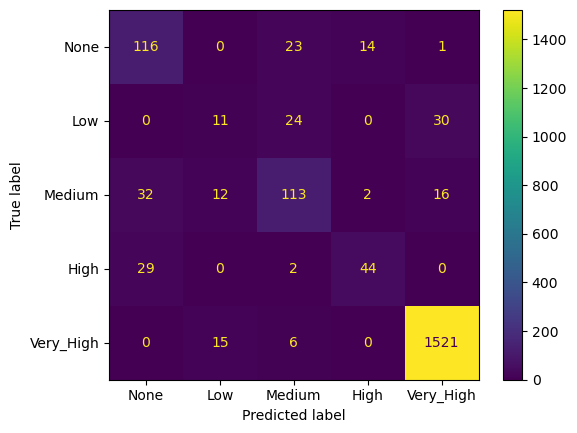

In [ ]:
cm = confusion_matrix(y_test,pred_rfc)
cmd = ConfusionMatrixDisplay(cm,display_labels=['None','Low','Medium','High','Very_High'])
cmd.plot()

In [ ]:
print(classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       154
           1       0.29      0.17      0.21        65
           2       0.67      0.65      0.66       175
           3       0.73      0.59      0.65        75
           4       0.97      0.99      0.98      1542

    accuracy                           0.90      2011
   macro avg       0.66      0.63      0.64      2011
weighted avg       0.89      0.90      0.89      2011



# Guardar Submissão

In [ ]:
# Fazer previsão com o DFC
predictions = clf.predict(teste)

# Adicionar header
submission = pd.DataFrame(predictions, columns = ["Injeção na Rede"]).head(2256)
submission.index.name = 'RowId'
submission.index += 1

# Trocar para valores categóricos
submission['Result'] = submission['Injeção na Rede'].replace({0:'None', 1:'Low', 2:'Medium', 3:'High', 4:'Very_High'})

#Passar para um ficheiro CSV
#submission.to_csv('submission.csv', index=True, header=True)

In [ ]:
# Fazer previsão com o BST
predictions = bst.predict(teste)

# Adicionar header
submission = pd.DataFrame(predictions, columns = ["Injeção na Rede"]).head(2256)
submission.index.name = 'RowId'
submission.index += 1
submission.rename(columns={'Injeção na Rede': 'Result'}, inplace=True)

# Trocar para valores categóricos
submission['Result'] = submission['Result'].replace({4:'None', 1:'Low', 2:'Medium', 0:'High', 3:'Very_High'})

#Passar para um ficheiro CSV
submission.to_csv('submission.csv', index=True, header=True)